# EPF - Electricity Spot Price Forecasting
24 march 2022  
@mzaffran


The aim of this notebook is to introduce some basic notions and tools from machine learning in order to forecast electricity spot prices (a time series) in a supervised approach.  
To do so, one has to deal with some pre-processing, data analysis, choice of a (or multiple) model(s), and the optimization of hyper-parameters.  
We look for accurate forecasting models but also for models able to generalize on unobserved data.

Let's denote the price at time $t$ $Y_t$.   
Assume we have some explanatory variables, $d$, in some $X_t$. $X_t$ contains $d$ columns, one for each variable.   We assume the following model: 
$$ Y_t = f(X_t) + \varepsilon_t$$
where $\varepsilon_t$ is stationary.  
We aim at finding the best $\hat{f}$ such that:
$$ Y_t = \hat{f}(X_t) + \hat{\varepsilon}_t$$
where $\hat{\varepsilon}_t$ is stationary.

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>


1. [Data preparation](#Data-preparation)
    1. [Data investigation](#Data-investigation)
    1. [Split the data before learning anything](#Split-the-data-before-learning-anything)
1. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
1. [Forecasting last semester of 2019](#Forecasting-last-semester-of-2019)
    1. [Tools](#Tools)
    1. [Optimize hyper-parameters](#Find-the-"best"-tree-and-forest)
    1. [Evaluation](#Evaluation-of-our-3-models)
    1. [Forecast last semester](#Forecast-last-semester)
1. [Adding useful features!](#Adding-useful-features!)
    1. [Lagged price](#Lagged-price)
    1. [Lagged price w.r.t. weekdays/weekends](#Lagged-price-w.r.t.-weekdays/weekends)
    1. [How to encode calendar variables?](#How-to-encode-calendar-variables?)
1. [Can we forecast 2020? 2021?](#Can-we-forecast-2020?-2021?)
    1. [2020](#2020)
    1. [2021](#2021)
        1. [Growing window](#Growing-window)
        1. [Rolling window](#Rolling-window)


[References](#References)

We start by some basics imports.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
url = "https://raw.githubusercontent.com/mzaffran/mzaffran.github.io/master/assets/files/Dauphine/Data_2018_2021.csv"
data = pd.read_csv(url)

# Data preparation

Back to [table of contents](#toc).

## Data investigation

<u>**Q1**</u> Print the dimension of the dataframe data.

<u>**Q2**</u> Show the first 10 and last 10 row of data.  

<u>**Q3**</u> Show the list of the columns names.  

_Tips: use Pandas commands, such as shape, head, and tail_

In [ ]:
## Your code here

<u>**Q4**</u> Analyze the _date_ column. What do you think of its format? Is it adequate?

In [ ]:
## Your code here

NaN values have to be taken huge care of. 
In this practical session, we will not focus on an adequate treatment since it is not the aim. 
Nevertheless, we will have to impute these values! This will be done after splitting the data set: we can not use the target / future values to impute to the old ones!

<u>**Q5**</u> Report the number of non-a-number (NaN) values for each columns.

In [ ]:
## Your code here

Every data analysis starts by having a look at your data. So let's go!


<u>**Q6**</u> Plot the french spot price on all the period.

In [ ]:
## Your code here

Here we are cheating a bit, in a pedagogical objective. We should not have a look at what we will try to predict! 

<u>**Q7**</u> What do you think of our explanatory variables? What is their temporality with respect to the the temporality of the target (i.e. of what we aim at predicting, the spot prices)? What do you propose? Do you think about a better approach?

In [ ]:
## Your code here

<u>**Q8**</u> What do you think will be the important and useful information from the _date_ variable? Extract them!

_Tips: use date.dt_

In [ ]:
## Your code here

## Split the data before learning anything

Back to [table of contents](#toc).

We aim at learning a general relationship between input features and a label/target.  
We wish to use this learnt relationship to predict on future unseen values.   
We will start by re-creating this setting: we will keeping some final values unused and try to predict them as if we were back on that time! But this time, we will be able to quantify our errors.

In addition to the pedagogical objective, it can also help us regarding overfitting.  
To avoid overfitting, or at least quantify it, we need to test our forecasting models on unobserved data during the training phase.   
A classical approach is to split a training and a testing set. The training set allows the calibration of the parameters of a model, while the testing set evaluates the generalization ability.  

<u>**Q9**</u> Create an extract of _data_, _data\_train_, where the data stops at 2019-06-30 23h. We keep the last semester of 2019 to predict. 
_Tips: Define limit_train, the date where the training set stops, and use this time stamp to extract data\_train._

In [ ]:
## Your code here

A commun flaw in data science is the missing values.  
Sometimes, using incomplete data could lead to ineffective analysis or erratic training of models.  
Data imputation is a research field at its own, with various methods (see [1]).  
An intuitive approach but non appropriate is to drop observations containing missing values, in order to keep a complete dataset.  
However, by definition every incomplete information is lost. Furthermore, if the missing values depend on your features or on your response, you could loose an entire relationship.  
There are many other ways to handle incomplete dataset: imputing by the mean, by a regression on the other variables, a stochastic regression, k-nearest neighbors and so on.  
In addition, you can sometimes add the treatment of your missing values in your procedure, without imputing beforehand!
As said, it is a very active field of research!

Here, we will impute our data, and regress afterwards (not combining both tasks). This is motivated by the work of Le Morvan et al. (2021) [2].  
We propose the fill missing values with mean, as it is simple and the practical session is not dedicated to study the missing values.

\[1\] https://rmisstastic.netlify.app/  
\[2\] [Le Morvan et al. (2021)](https://proceedings.neurips.cc/paper/2021/file/5fe8fdc79ce292c39c5f209d734b7206-Paper.pdf)

We can now impute our data set, without using the unseen values.

<u>**Q10**</u> Replace NaN values by the associated variable's means of _data\_train_.  

The test set (not created yet, that will contain the last 6 months of 2019) shall not contain missing values either!

<u>**Q11**</u> Replace also NaN values of the overall _data_ with the same means of _data\_train_.

In [ ]:
## Your code here

# Exploratory Data Analysis

Back to [table of contents](#toc).

Several basic tools are useful to better understand the data.  
Here we propose to explore some of them.  
We focus of analysing the training set, to avoid adding some prior of events which did not occur yet.  
A major task in data analysis is the study of the relationship between a given feature and the target, since it is what we are trying to learn. We will try to get some insights on these relationships.

<u>**Q12**</u> Plot the histogram of the french spot prices. It illustrates the probability distribution of the data.

In [ ]:
## Your code here

The previous histogram only displays the overall distribution. We added some calendar information, we can try to assess the relations between the price and these calendar information!

<u>**Q13**</u> Show the boxplot of the french spot prices by _Weekday_, _Month_ and _Hour_.

Boxplots illustrate average and spread of a given variable.

In [ ]:
## Your code here

We observe patterns, on the mean but also on the variance, depending on these calendar variables:
- lower and less variable prices on the week-end (lower industrial consumption)
- higher prices in Fall and Winter (higher consumption)
- prices more variable in Winter (lower renewable production)
- lower prices during the nighs, and peaks around 9 a.m. and 6 p.m. with huge variance at 6 p.m.

<u>**Q14**</u> What is the limitation of boxplots?

Violin plots are similar to box plots but shows the estimated probability density as well.  
One can see the references to go further on the violin plots:  
https://en.wikipedia.org/wiki/Violin_plot   
https://seaborn.pydata.org/generated/seaborn.violinplot.html  
https://chartio.com/learn/charts/violin-plot-complete-guide/  
https://mode.com/blog/violin-plot-examples/  

<u>**Q15**</u> Show the boxplot of the french spot prices by _Weekday_, _Month_ and _Hour_.

In [ ]:
## Your code here

Sometimes, plotting this relationship between two series of data in a graph allows to better understand it, or exhibits linear or polynomial relations.

<u>**Q16**</u> Plot the french spot price according to each variables, with its label in absciss.

<u>**Q17**</u> When/what can you conclude?

_Tips: use scatter plot_

In [ ]:
## Your code here

<u>**Q18**</u> Plot the correlation matrice between all variables. What can you say?

_Tips: use corr function and heatmap_

In [ ]:
## Your code here

Warning: correlation is not causality. This is just a hint, nothing more!

# Forecasting last semester of 2019

Back to [table of contents](#toc).

Having analysed our data, we can proceed to the forecasting task. First, we need to create our testing set.

<u>**Q19**</u> Define _data\_test_, stopping at 2019-12-31 23h.

In [ ]:
## Your code here

## Tools

Back to [table of contents](#toc).

#### Split X and Y

Models will need to distinguish between variables/features (the X) and the response (the Y).

<u>**Q20**</u> Define X_train and Y_train.

In [ ]:
## Your code here

#### Metrics

We will evaluate the different forecasting models with three metrics. Many more would be available!  

R2 : $$R2 = 1- \frac{\sum^T_{t=1} (y_t - \hat{y_t})^2}{\sum^T_{t=1} (y_t - \bar{y})^2}$$
Mean Absolute Error : $$MAE(y_t,\hat{y_t}) =\frac{1}{T}\sum^T_{t=1} |y_t - \hat{y_t}|$$
Mean Squared Error :  $$MSE(y_t,\hat{y_t}) = \frac{1}{T}\sum^T_{t=1} (y_t - \hat{y_t})^2$$
where vectors $y_t$ and $\hat{y_t}$ are respectively the real values to be predicted and the predictions, $\bar{y}$ is the average of $y_t$.

- The MSE reports the squared error of the predictions, and is very sensitive to the outliers to improve the estimation accuracy. The lower, the better. To keep the same unit, we prefer to report the Root Mean Squared Error: $\sqrt{MSE}$.  
- The MAE reports the absolute error of the predictions. As the MSE, the lower the better, but it is less sensitive to outliers.  
- The R2 represents the proportion of the variance for a dependent variable that is explained by a collection of variables. It is a correlation coefficient (so the same precautions that we take regarding correlations has to be taken with respect to R2). In the best case, the modeled values exactly match the observed values, which results in R2 = 1. A baseline model, which always predicts $\bar{y}$ , will have R2 = 0. Models that have worse predictions than this baseline will have a negative R2. See more in the [wiki page](https://en.wikipedia.org/wiki/Coefficient_of_determination).

<u>**Q21**</u> Define a function _regression\_results_ taking true and predicted values, and printing the R2, MAE and RMSE scores.

In [43]:
import sklearn.metrics as metrics

In [ ]:
## Your code here

#### Models

**Linear regression**  
Linear regression models the label (or target) $y\in\mathbb{R}$ as a linear combination of the $d$-dimensional input $x \in \mathbb{R}^d$:
$$\hat{y}(w,x)=w_0+w_1x_1+\dots+w_dx_d$$
 
The parameter $w=(w_0,\dots,w_d)\in \mathbb{R}^{d+1}$ is fitted by minimizing the loss function $\ell(w)$ on the data, according to $w$:
$$\ell(w) = ||y - X w||^2_2 = \sum_{i=1}^N (y_i - x_i^T w)^2$$

For further details, see  https://scikit-learn.org/stable/modules/linear_model.html


**Decision tree**  
Decision trees learn a hierarchy of “if-else” questions, leading to a decision. For instance, is the given value (e.g. the consumption) greater than 1.3?
The collection of questions can be expressed as a decision tree, where each node characterizes a question and a leaf (a terminal node) indicates an answer.   
Find more [details on CART trees](https://scikit-learn.org/stable/modules/tree.html).

The more nodes a tree has, the more it is precise, but may lack of generalization! The rules would be too much fitted to represented *perfectly* the data the tree has already seen.  
The depth of a tree is a hyper-parameter to be optimized, as well as the minimum number of examples per leaf.  
Overall, this can be done by using the following procedure (detailed [here](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning)):
- growing the maximal tree,
- pruning the tree with an adequate complexity parameter, in order to find the best hyper-parameters avoiding overfitting.  

**Random Forests**  
Random Forests belong to the ensemble methods, which combine multiple models to improve the prediction.  
As mentioned, a main drawback of decision trees is the overfitting tendency on the training data. Random forest considers a collection of (slightly) different decisions trees.  
By averaging many trees, random forest is able to preserve prediction efficiency of trees while preventing overfitting.  
Each tree is build with only a random set of features and random observations from the training set.  
There is two main hyper-parameters, the number of considered trees and their depth.

For further details, see  https://en.wikipedia.org/wiki/Random_forest  
To see examples, see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#examples-using-sklearn-ensemble-randomforestregressor

<u>**Q22**</u> Import from sklearn the models: LinearRegression, DecisionTreeRegressor, RandomForestRegressor

In [ ]:
## Your code here

How to select hyper-parameters, models? **Cross-validation!**

Cross-validation is a statistical method for evaluating the performance of machine learning models. 
When a model is trained on labeled data, it is assumed that it should also work on new data.  
First, the data set is randomly split into K folds. The procedure has a single parameter called 'K' referring to the number of groups into which the sample will be splitted.   
The process is repeated until each K-fold serves within the training set.   
The average of the recorded scores is the performance metric of the model.

<img src="img/KFoldSplit.png" alt="Drawing" style="width: 600px;"/>

_Source images: scikit-learn, link below_

When considering time series forecasting, some precautions have to be taken in order to preserve temporality. We do not want to learn to predict past values from futures ones! That is why, we consider a time series split.

<img src="img/timeseriessplit.png" alt="Drawing" style="width: 600px;"/>

_Source images: scikit-learn, link below_

After training a model for several hyper-parameters, one can compare the performances of each associated prediction and identify the best parameter.

See https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data

<u>**Q23**</u> Import _TimeSeriesSplit_, _GridSearchCV_ and _cross\_val\_score_ from sklearn, and create a time series splitter into approximately 2 months folds.

<u>**Q24**</u> Create a scorer based on the MSE.

_Tips: use make\_scorer from sklearn.metrics to ease the task, and think about whether you prefer a high or a low score_

In [ ]:
## Your code here

## Find the "best" tree and forest

Back to [table of contents](#toc).

<u>**Q25**</u> Find the optimal tree: instanciate your tree model, and compare different versions of it using various parameters of complexity (let's say starting from 0 until 0.5 with 50 equally spaced values).

_Tips: use linspace from numpy to create your set of control values, and use GridSearchCV to compare the different values_

In [ ]:
## Your code here

<u>**Q26**</u> Plot the MSE score with respect to the control parameter.

In [ ]:
## Your code here

<u>**Q27**</u> Optimize Random Forest hyper-parameters, using a similar approach than previously. We will compare forests with 50, 100 and 200 trees, that has maximal depth ranging from 10 to 30

_Tips: find which parameters correspond to the number of trees in the RandomForestRegressor function, and which correspond to maximal depth, use arange from numpy to create a sequential list of integers between two bounds_

In [ ]:
## Your code here

## Evaluation of our 3 models

Back to [table of contents](#toc).

<u>**Q28**</u> Using _cross\_val\_score_, print the averaged scores of each model. We have access to a variation of this score, since we have 8 evaluations. Displays also their boxplot!

_Tips: recall that we took the opposite of the MSE in the scorer_

In [ ]:
## Your code here

## Forecast last semester

Back to [table of contents](#toc).

We can now try to forecast last semester of 2019!

<u>**Q29**</u> As for the training, define X_test and Y_test.

In [ ]:
## Your code here

The values of the RMSE and the MAE does are not enough to quantify the performances of our algorithm. We need to relate to a baseline/naive model.

<u>**Q30**</u> Which naive predictor do you propose? Implement it!

In [ ]:
## Your code here

<u>**Q31**</u> Fit our 3 models on the training data, and predict on the testing one.

In [ ]:
## Your code here

<u>**Q32**</u> Print and compare the performances of the predictions.

_Tips: use our custom function regression\_results_

In [ ]:
## Your code here

<u>**Q33**</u> Plot the realized prices and our predictions for the first week of our test data. Add a legend.

In [ ]:
## Your code here

Analyzing our forest. What is **feature importance**?

Feature importance assigns a score of input features based on their influence to predict the target.  
The more the features will be "responsible" to predict the target the greater will be their score. 
Feature importance allows a better interpretability of the variables and the forest (indeed, how can we interpret an averaged of 200 trees?).
Several approach to compute these scores are proposed in the litterature, depending on the chosen models.

Mean Decrease Impurity (MDI) is one of the variable importance measures in random forests. 
Few theoretical justifications to use MDI are available.
In particular, a paper (Scornet (2021)) analyzes MDI and proves that if input variables are independent and in absence of interactions, MDI provides a variance decomposition of the output, where the contribution of each variable is clearly identified. 


https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html   
[Scornet (2021)](https://arxiv.org/pdf/2001.04295.pdf)  
[Genuer, Poggi and Tuleau (2008)](https://arxiv.org/abs/0811.3619)  
[Genuer, Poggi and Tuleau (2010)](https://hal.archives-ouvertes.fr/hal-00755489/document)

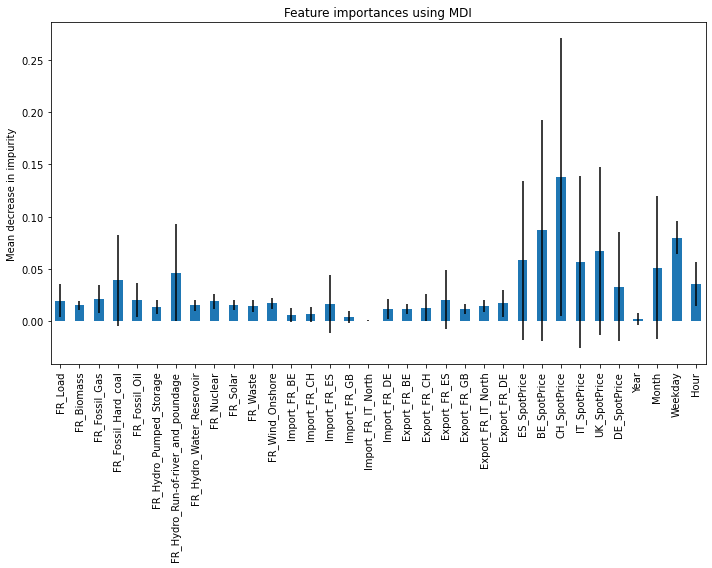

In [65]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=data_train.iloc[:,2:data_train.shape[1]].columns)

fig, ax = plt.subplots(figsize=(10,8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

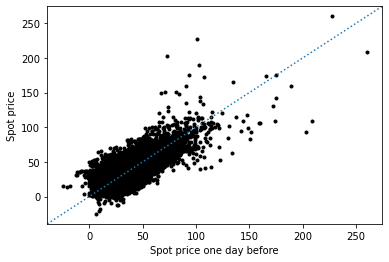

In [66]:
fig, ax = plt.subplots()
ax.scatter(data_train.FR_SpotPrice.shift(24), data_train.FR_SpotPrice, marker='.', color='black')
ax.set_ylabel("Spot price")
ax.set_xlabel("Spot price one day before")
ax.plot([0,1],[0,1], transform=ax.transAxes, linestyle=':')
plt.show()

# Adding useful features!

Back to [table of contents](#toc).

<u>**Q34**</u> Given than the naive predictor is better than us, what could you suggest?

## Lagged price

<u>**Q34**</u> Create this new feature and add it.

In [ ]:
## Your code here

<u>**Q35**</u> Recreate the training and test set with this added feature. What do you have to be careful at?

In [ ]:
## Your code here

<u>**Q36**</u> Fit again the models, predict and analyze.

_NB: we should re-do the optimization of the hyper-parameters for the tree and the forest. Because of their computational time, we do not do it here, and keep the previous models_

In [ ]:
## Your code here

## Lagged price w.r.t. weekdays/weekends

<u>**Q37**</u> It is better, but do you think our lags make sense given the weekly pattern of our data? Improve the lags! And redo all the analysis.

In [ ]:
## Your code here

## How to encode calendar variables?


<u>**Q38**</u> We have encoded the calendar with integers. What do you think about it? 

There are many ways you could deal with periodicity. One of them is to use sine and cosine transforms.

To further details, see https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html#sphx-glr-auto-examples-applications-plot-cyclical-feature-engineering-py

In [80]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

### Hour

<u>**Q39**</u> Implement this transformation for the hour.

In [ ]:
## Your code here

<u>**Q40**</u> Create the new data sets and refit, redo the analysis.

In [ ]:
## Your code here

<u>**Q41**</u> How do you explain that we have improved Random Forest but deteriorated the linear regression?

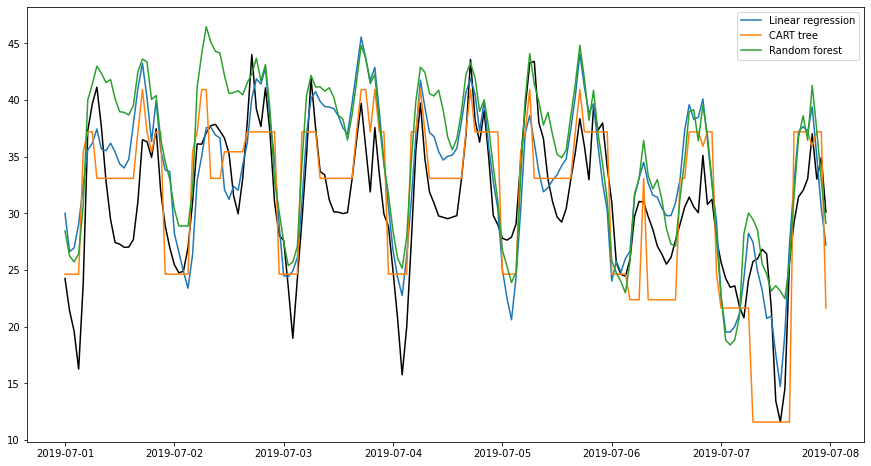

In [87]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(data_test.date[0:24*7], data_test.FR_SpotPrice[0:24*7], color='black')
ax.plot(data_test.date[0:24*7], lr_pred[0:24*7], label="Linear regression")
ax.plot(data_test.date[0:24*7], cart_pred[0:24*7], label="CART tree")
ax.plot(data_test.date[0:24*7], rf_pred[0:24*7], label="Random forest")
ax.legend()
plt.show()

### Month

<u>**Q42**</u> Let's do the same for the month!

In [ ]:
## Your code here

### Final models

<u>**Q43**</u> To conclude, which model would you keep for each method?

In [94]:
data_train = data.loc[data.date <= limit_train,:].drop(["Hour", "Month"], axis=1)
data_train_lr = data.loc[data.date <= limit_train,:].drop(["Hour_sin","Hour_cos","Month_sin","Month_cos"], axis=1)
data_train = data_train.drop(np.arange(168), axis=0) ## Initials NA because of lagged variables
data_train_lr = data_train_lr.drop(np.arange(168), axis=0)
data_test = data.loc[(data.date > limit_train) & (data.date <= limit_test),:].drop(["Hour", "Month"], axis=1)
data_test_lr = data.loc[(data.date > limit_train) & (data.date <= limit_test),:].drop(["Hour_sin","Hour_cos","Month_sin","Month_cos"], axis=1)
X_train = data_train.iloc[:,2:data_train.shape[1]]
X_train_lr = data_train_lr.iloc[:,2:data_train_lr.shape[1]]
Y_train = data_train.loc[:,'FR_SpotPrice']
X_test = data_test.iloc[:,2:data_test.shape[1]]
X_test_lr = data_test_lr.iloc[:,2:data_test_lr.shape[1]]
Y_test = data_test.loc[:,'FR_SpotPrice']

We have assessed their performance predictions, but not the shape of their errors. This should always be done before any forecast (that is, again, using cross validation): if your errors still contain dependency, or are not zero-centered (among other things) this is highly problematic!

<u>**Q44**</u> Get the residuals ($y_t - \hat{y}_t$) of the cross-validation.

_Tips: we can not use any built-in method from sklearn. Code your loop, using the tscv object previously created_

In [ ]:
## Your code here

<u>**Q45**</u> Plot these residuals. What do you observe? Can you explain it?

In [ ]:
## Your code here

<u>**Q46**</u> Display their histogram.

In [ ]:
## Your code here

Autocorrelation and Partial Auto-Correlation functions allow to analyse the correlation of a serie to its past. 

<u>**Q47**</u> Using _plot\_acf_, _plot\_pacf_ from statsmodels.graphics.tsaplots, show their autocorrelations. What do you observe? Do you expect it?

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
## Your code here

Note here that this should *absolutely* be done for our 3 models. For time considerations, we only do it for the linear regression here.

In [108]:
lr = LinearRegression()
lr.fit(X_train_lr, Y_train)
cart_tree.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

RandomForestRegressor(max_depth=16, max_features='sqrt', n_estimators=200,
                      random_state=0)

In [109]:
cart_pred = cart_tree.predict(X_test)
rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test_lr)

In [110]:
print('Naive predictor')
regression_results(Y_test, naive_pred)
print('--------------')
print('Linear regression')
regression_results(Y_test, lr_pred)
print('--------------')
print('CART tree')
regression_results(Y_test, cart_pred)
print('--------------')
print('Random forest')
regression_results(Y_test, rf_pred)

Naive predictor
r2:  0.4836
MAE:  6.4115
RMSE:  8.8177
--------------
Linear regression
r2:  0.6496
MAE:  5.581
RMSE:  7.2641
--------------
CART tree
r2:  0.5523
MAE:  6.04
RMSE:  8.2108
--------------
Random forest
r2:  0.6127
MAE:  5.7984
RMSE:  7.6371


# Can we forecast 2020? 2021?

Back to [table of contents](#toc).

Now that we have selected our models and assessed that their errors are approximately acceptable, we can try to forecast more difficult periods: 2020 with the quarantine, and 2021 with th price explosion in Fall.

## 2020

Let's start with 2020. 

<u>**Q48**</u> Redefine the training and testing data sets: training end at 2019-12-31 23 and testing at 2020-12-31 23.

In [ ]:
## Your code here

<u>**Q49**</u> Regenerate the dumb predictor.

In [ ]:
## Your code here

<u>**Q50**</u> And let's go! Fit, predict and compare. What can you say?

In [ ]:
## Your code here

The errors are deteriorated, but not that much, and still better than the naive. In practice, we should dive into what happens in March and April, with the huge negative prices. If you are interested, you can do this job and try to improve your model :) In class, we will jump onto 2021, which is also super interesting!

## 2021

Back to [table of contents](#toc).

<u>**Q51**</u> Redefine the training and testing data sets: training end at 2020-12-31 23 and testing at 2021-12-31 23.

In [ ]:
## Your code here

<u>**Q52**</u> Regenerate the dumb predictor.

In [ ]:
## Your code here

<u>**Q53**</u> Here we go, predict and analyze.

In [ ]:
## Your code here

<u>**Q54**</u> Let's cheat a bit: plot the prices in 2021.

In [ ]:
## Your code here

We can evaluate the evolution of our errors with time. To do so, implement a moving average average function that should average only around $w$ points symetrically distributed around each $x$.

<u>**Q55**</u> Create the moving average function.

_Tips: use convolve from numpy_

In [ ]:
## Your code here

<u>**Q56**</u> Apply this function on our errors (RMSE) with a window of size approximately one month. Plot these errors.

In [ ]:
## Your code here

<u>**Q57**</u> What can you propose as solution to improve the models?

### Growing window?

Back to [table of contents](#toc).

In [132]:
n_test = data_test.shape[0]

lr_pred = np.array([])
cart_pred = np.array([])
rf_pred = np.array([])

In [133]:
from dateutil.relativedelta import relativedelta

In [134]:
limit_train + relativedelta(months=0)

datetime.datetime(2020, 12, 31, 23, 0)

TQDM is a really useful package allowing you to monitor the time consumption of a loop, as well as its expected time before it finishes.

In [135]:
from tqdm.autonotebook import tqdm

<ipython-input-135-d05506e76d3e>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [136]:
for m in tqdm(range(12)):
    
    limit_train_window = limit_train + relativedelta(months=m)
    limit_test_window = limit_train + relativedelta(months=m+1)
    
    data_train = data.loc[data.date <= limit_train_window,:].drop(["Hour", "Month"], axis=1)
    data_train_lr = data.loc[data.date <= limit_train_window,:].drop(["Hour_sin","Hour_cos","Month_sin","Month_cos"], axis=1)
    data_train = data_train.drop(np.arange(168), axis=0) ## Initials NA because of lagged variables
    data_train_lr = data_train_lr.drop(np.arange(168), axis=0)
    data_test = data.loc[(data.date > limit_train_window) & (data.date <= limit_test_window),:].drop(["Hour", "Month"], axis=1)
    data_test_lr = data.loc[(data.date > limit_train_window) & (data.date <= limit_test_window),:].drop(["Hour_sin","Hour_cos","Month_sin","Month_cos"], axis=1)
    X_train = data_train.iloc[:,2:data_train.shape[1]]
    X_train_lr = data_train_lr.iloc[:,2:data_train_lr.shape[1]]
    Y_train = data_train.loc[:,'FR_SpotPrice']
    X_test = data_test.iloc[:,2:data_test.shape[1]]
    
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    cart_tree.fit(X_train, Y_train)
    rf.fit(X_train, Y_train)
        
    lr_pred = np.append(lr_pred, lr.predict(X_test))
    cart_pred = np.append(cart_pred, cart_tree.predict(X_test))
    rf_pred = np.append(rf_pred, rf.predict(X_test))

In [137]:
print('Naive predictor')
regression_results(Y_test, naive_pred)
print('--------------')
print('Linear regression')
regression_results(Y_test, lr_pred)
print('--------------')
print('CART tree')
regression_results(Y_test, cart_pred)
print('--------------')
print('Random forest')
regression_results(Y_test, rf_pred)

Naive predictor
r2:  0.8564
MAE:  19.7378
RMSE:  31.9436
--------------
Linear regression
r2:  0.8629
MAE:  19.5422
RMSE:  31.2188
--------------
CART tree
r2:  0.7761
MAE:  24.4172
RMSE:  39.8966
--------------
Random forest
r2:  0.7641
MAE:  26.2551
RMSE:  40.9468


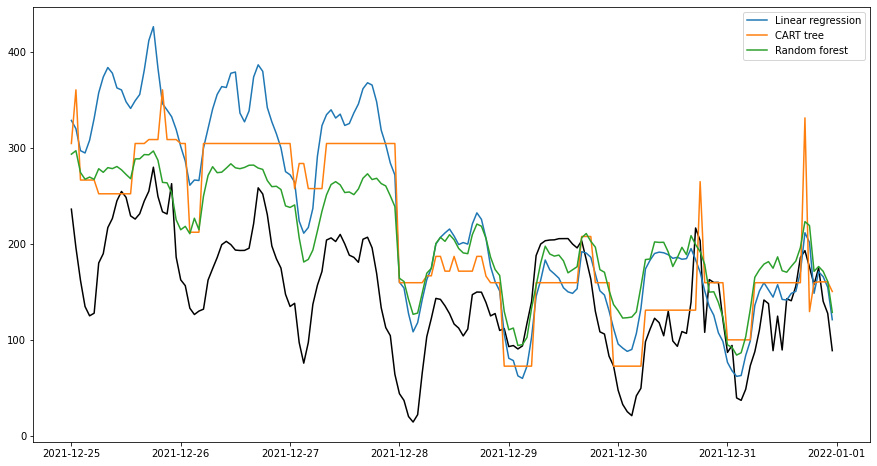

In [138]:
limit_train = datetime.strptime('2020-12-31 23:00:00', "%Y-%m-%d %H:%M:%S")
limit_test = datetime.strptime('2021-12-31 23:00:00', "%Y-%m-%d %H:%M:%S")
data_train = data.loc[data.date <= limit_train,:]
data_test = data.loc[(data.date > limit_train) & (data.date <= limit_test),:]

fig, ax = plt.subplots(figsize=(15,8))
end = data_test.shape[0]
ax.plot(data_test.date[(end-24*7):end], data_test.FR_SpotPrice[(end-24*7):end], color='black')
ax.plot(data_test.date[(end-24*7):end], lr_pred[(end-24*7):end], label="Linear regression")
ax.plot(data_test.date[(end-24*7):end], cart_pred[(end-24*7):end], label="CART tree")
ax.plot(data_test.date[(end-24*7):end], rf_pred[(end-24*7):end], label="Random forest")
ax.legend()
plt.show()

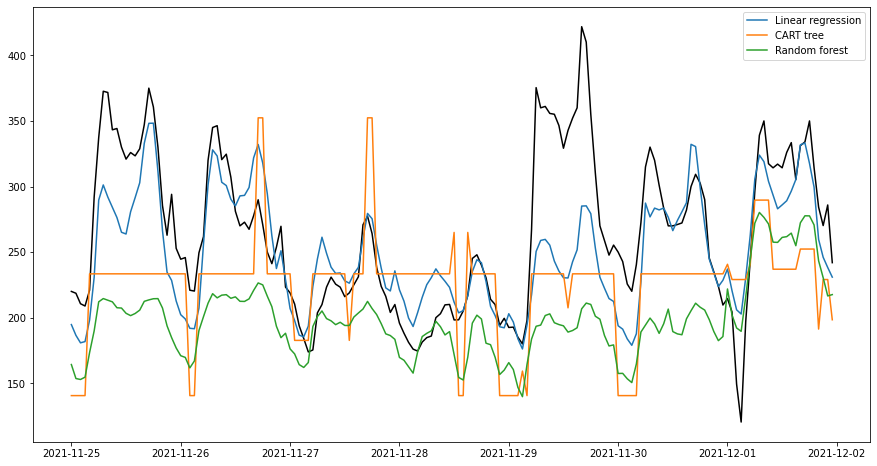

In [139]:
fig, ax = plt.subplots(figsize=(15,8))
end = data_test.shape[0]
ax.plot(data_test.date[(end-24*37):(end-24*30)], data_test.FR_SpotPrice[(end-24*37):(end-24*30)], color='black')
ax.plot(data_test.date[(end-24*37):(end-24*30)], lr_pred[(end-24*37):(end-24*30)], label="Linear regression")
ax.plot(data_test.date[(end-24*37):(end-24*30)], cart_pred[(end-24*37):(end-24*30)], label="CART tree")
ax.plot(data_test.date[(end-24*37):(end-24*30)], rf_pred[(end-24*37):(end-24*30)], label="Random forest")
ax.legend()
plt.show()

We have managed to improve our performances, and bit our naive predictor. 

<u>**Q58**</u> Do you think that we can do better? How?

### Rolling window?

Back to [table of contents](#toc).

<u>**Q59**</u> Implement the rolling window, predict using it and comment.

In [ ]:
## Your code here

# References and going further

Will be added this afternoon!